<a href="https://colab.research.google.com/github/satyam-tomar/neural-networks/blob/main/sentiment_classification_bag_of_words_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Classification — Bag-of-Words Baseline

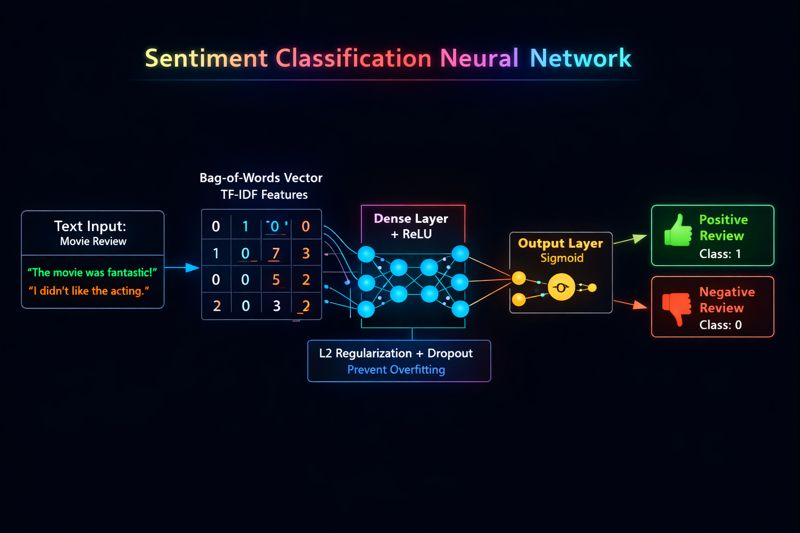

In [1]:
from IPython.display import Image, display
display(Image("sentiment_classification_nn.png"))



| Step | Approach | Description | Details / Notes |
| --- | --- | --- | --- |
| 1 | Baseline | Bag-of-words + Dense layer | Convert text to a bag-of-words vector, feed into a simple dense neural network. Fast to train, provides a basic benchmark, but ignores word order and context. Useful to compare improvements from later models. |
| 2 | RNN / CNN | Embedding + LSTM or CNN | Map words to embeddings, then process with LSTM (captures sequential dependencies) or 1D CNN (captures local patterns). Handles context better than bag-of-words and improves accuracy on longer sentences. Moderate training time. |
| 3 | Transformer | Small transformer-based model | Uses attention mechanisms to capture relationships between all words in a sequence simultaneously. Can be implemented with libraries like Hugging Face. Provides best performance for nuanced sentiment, supports pretraining, mirrors MNIST → TensorFlow progression in sophistication. |

This notebook implements a baseline sentiment classification model using a bag-of-words representation and a simple dense neural network. The goal of this stage is not to achieve state-of-the-art performance, but to establish a clear reference point before moving to more advanced architectures.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [2]:
import zipfile
import os

zip_name = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
  zip_ref.extractall("/content/sentement_dataset")

In [3]:
import os
import shutil

macosx_path = "/content/sentement_dataset/__MACOSX"

if os.path.exists(macosx_path):
  shutil.rmtree(macosx_path)

The dataset consists of positive and negative movie reviews stored as raw text files. Each review is converted into a fixed-length vector using TF-IDF weighting, which captures word importance but ignores word order and context. This makes the model fast and easy to train, but also limited in expressive power.

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load text files
def load_reviews(path):
    texts = []
    labels = []
    for label_type in ['pos', 'neg']:
        dir_path = os.path.join(path, label_type)
        for fname in os.listdir(dir_path):
            if fname.endswith(".txt"):
                with open(os.path.join(dir_path, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)
    return texts, np.array(labels)

train_texts, train_labels = load_reviews('/content/sentement_dataset/dataset/train')
test_texts, test_labels = load_reviews('/content/sentement_dataset/dataset//test')

# 2. Tokenize and create bag-of-words vectors
vocab_size = 10000  # you can adjust this
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_texts)  # fit on training data

# Convert text to integer sequences
train_sequences = tokenizer.texts_to_matrix(train_texts, mode='tfidf') #model changes from binary because of validation pipeline broken
test_sequences = tokenizer.texts_to_matrix(test_texts, mode='tfidf')

print("Shape of train vectors:", train_sequences.shape)
print("Shape of test vectors:", test_sequences.shape)


Shape of train vectors: (25000, 10000)
Shape of test vectors: (25000, 10000)


In [5]:
print(len(train_texts), np.unique(train_labels, return_counts=True))
print(len(test_texts), np.unique(test_labels, return_counts=True))

25000 (array([0, 1]), array([12500, 12500]))
25000 (array([0, 1]), array([12500, 12500]))


The reason 10,000 is common is that word frequency follows Zipf’s law: a small number of words cover most of the text. In IMDB, the top 10,000 words already cover the vast majority of word occurrences.

In [6]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_sequences, train_labels)
)

train_ds = train_ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_sequences, test_labels)
)

test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential([
    Input(shape=(vocab_size,)),
    # Dense(128, activation='relu'),
    Dense(128, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.5),
    # Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

The neural network used here is intentionally shallow: a single hidden dense layer with L2 regularization and dropout, followed by a sigmoid output for binary classification. This design keeps the model simple and interpretable while still allowing it to learn useful word-level patterns.

In [11]:
model.compile(
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [14]:
model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 10,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9758 - loss: 0.0856 - val_accuracy: 0.6476 - val_loss: 1.7542
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9806 - loss: 0.0764 - val_accuracy: 0.6566 - val_loss: 1.7354
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9835 - loss: 0.0670 - val_accuracy: 0.6610 - val_loss: 1.7742
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9843 - loss: 0.0597 - val_accuracy: 0.6691 - val_loss: 1.7791


During training, the model quickly reaches very high training accuracy (around 98%), while validation and test accuracy remain in the 64–66% range. This gap clearly indicates overfitting, which is expected for a bag-of-words model with a large vocabulary and limited regularization *(intentionally restricts the model’s freedom so it cannot memorize the training data too precisely)*, *(L2 regularization adds a penalty to large weights)*. At this stage, overfitting is not treated as a failure, but as a learning signal.

In [16]:
loss, acc = model.evaluate(test_ds)
print(acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4236 - loss: 2.9199
0.6565999984741211


This result highlights an important limitation of bag-of-words approaches: they treat text as unordered tokens and cannot model sequence, negation, or contextual relationships between words. Improving validation performance therefore requires changing the representation, not just tuning hyperparameters.

For this reason, this baseline serves as a benchmark. In the next iterations of the project, the model will move to embedding-based architectures such as LSTM and CNN, and later to transformer-based models. Each step increases representational capacity in the same way earlier projects progressed from MNIST from scratch to TensorFlow-based implementations.